In [ ]:
# might need to install ipympl
!conda install --yes ipympl
!conda install --yes pytorch

In [1]:
import numpy as np
from math import cos, sin, pi, sqrt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans, whiten

from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

%matplotlib widget
# %matplotlib notebook

# seed the pseudo random number generator with 0 
# so that the results are consistent in all discussion sections
np.random.seed(0)

import IPython
from ipywidgets import interactive, widgets
from IPython.display import display, HTML

# autodifferentiation 
import torch 
import torch.autograd as autograd

## (a) Visualizing Cost Functions
The decision boundary we recover by optimizing, depends on the choice of the cost function. Real-life datasets are often noisy, e.g there might be outlier points due to error in measurement. In this notebook we investigate the sensitivity of different loss functions to outliers.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
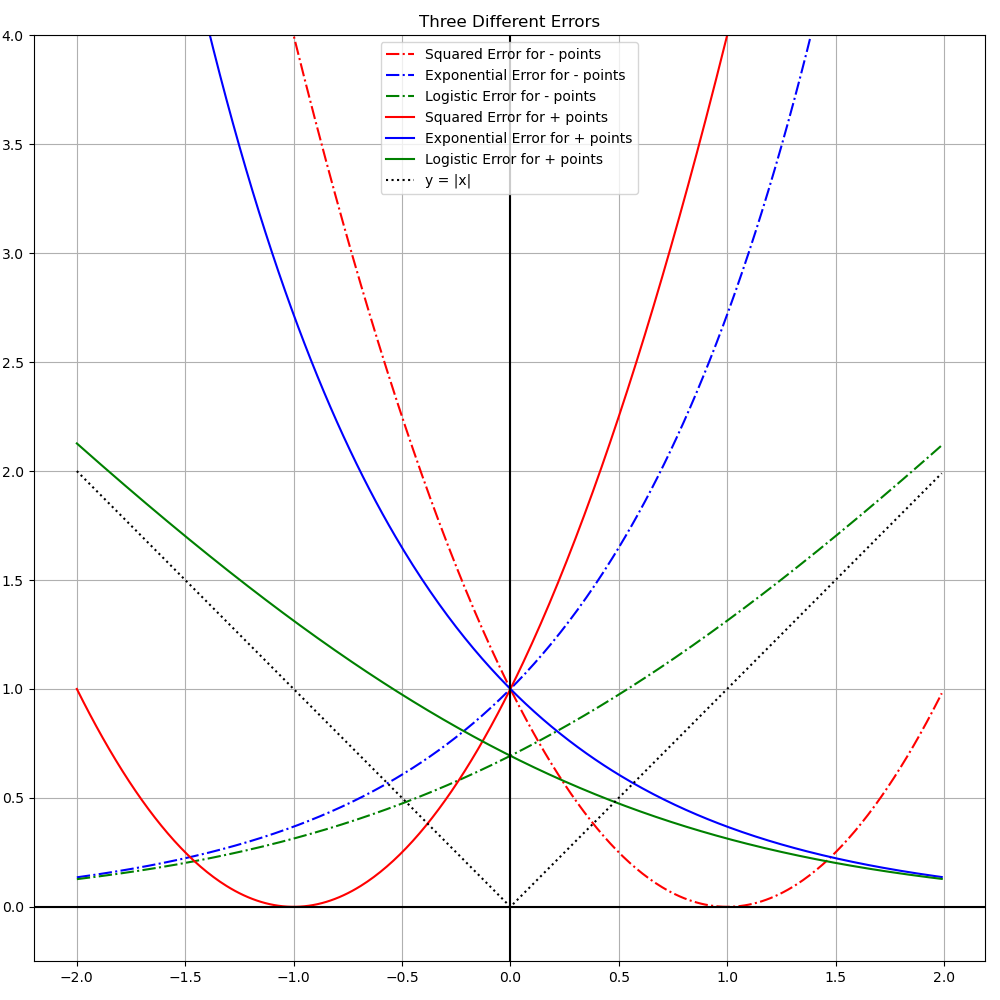

In [2]:
line_x = np.arange(-2, 2, 0.01)
squared_error = [(i-1)**2 for i in line_x]
squared_error_minus = [(i+1)**2 for i in line_x]
exp_error = np.exp(line_x)
exp_error_minus = np.exp(-line_x)
logistic_error = np.log(1+np.exp(line_x))
logistic_error_minus = np.log(1+np.exp(-line_x))
abs_val = np.abs(line_x)


fig, ax = plt.subplots(figsize = (10,10))
ax.grid(True, which='both')
plt.plot(line_x, squared_error, '-.', label='Squared Error for - points', color='r')
plt.plot(line_x, exp_error, '-.', label='Exponential Error for - points', color='b')
plt.plot(line_x, logistic_error, '-.', label='Logistic Error for - points', color='g')
plt.plot(line_x, squared_error_minus, label='Squared Error for + points', color='r')
plt.plot(line_x, exp_error_minus, label='Exponential Error for + points', color='b')
plt.plot(line_x, logistic_error_minus, label='Logistic Error for + points', color='g')
plt.plot(line_x, abs_val, ':', label='y = |x|', color='k')
plt.title('Three Different Errors')
plt.tight_layout()
plt.legend()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_ylim([-0.25,4])
plt.show()

## (b) Automatic-Differentiation

In the worksheet, we derived a second order linearization of the total cost function, which has the following form 
$$c_{total}(\vec{w}^\star + \Delta \vec{w}) \approx \sum_{i=1}^m \Big[ c(\vec{w}^\star) +D_{\vec{w}} c \Big\rvert_{\vec{w}^\star} \Delta \vec{w} + \frac{1}{2} \Delta \vec{w}^T  H_{\vec{w}}(c) \Big\rvert_{w^\star}  \Delta w \Big]$$
The above expression requires us to compute the derivative and hessian of $c(\vec{w})$. Instead of computing these expressions manually, we'll see how automatic-differentiation libraries solve this problem. The ideas introduced here, power the state-of-the-art neural networks which require millions of gradient computations to solve an optimization problem.

Consider the following optimzation problem
$$\min_{\vec{w}} \|\vec{w}\|_2^2$$
where $w \in \R^2$. This is akin to finding a $\vec{w}$ which minimizes the cost function $c(\vec{w})=\|\vec{w}\|_2^2$. To solve this problem, we consider two approaches  
(i) with **derivative** : $\vec{w}_{t+1} = \vec{w}_t - D_{\vec{w}}c^\top \Big\rvert_{\vec{w}_t}$  
(i) with **hessian** : $\vec{w}_{t+1} = \vec{w}_t - H_{\vec{w}}^{-1} c\Big\rvert_{\vec{w}_t} D_{\vec{w}}c^\top \Big\rvert_{\vec{w}_t} \hspace{3cm}$   (motivated by 2nd order approximation)

In [3]:
def squared_fn(x):
    squared = x**2 
    return squared.sum(axis=-1)

def plot_loss_surface_and_updates(loss_fn, xinit=2., yinit=2., num_gradient_steps=5, learning_rate=0.75, show_optimal=False):
    xs = np.arange(-xinit-1, xinit+1, 0.01)
    ys = np.arange(-yinit-1, xinit+1, 0.01)

    X, Y = np.meshgrid(xs, ys)
    points = np.concatenate((X[:, :, None], Y[:, :, None]), axis=-1)
    Z = loss_fn(points)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
    ax.plot_surface(X, Y, Z, alpha=0.2, color='red')

    ## take a random point
    X_t = torch.tensor([xinit, yinit])
    F_t = loss_fn(X_t)
    ax.scatter(*X_t, F_t, color='red',marker='x', linewidth=8, label='init')

    ## we consider two updates
    # (i) gradient based updates 
    num_gd_steps = 5
    # fixing learning rate = 1.0
    learning_rate = learning_rate

    points = []
    for step in range(num_gd_steps):
        points.append([X_t[0], X_t[1], F_t])
        grad = autograd.functional.jacobian(loss_fn, X_t)
        print(grad)
        X_tp1 = X_t - learning_rate * grad
        F_tp1 = loss_fn(X_tp1)
        X_t = X_tp1
        F_t = F_tp1

    points = np.array(points)
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color='black', marker='v', linewidth=1, label='gradient', linestyle='dashed')

    # (ii) using the Hessian
    X_t = torch.tensor([xinit, yinit])
    F_t = loss_fn(X_t)

    grad = autograd.functional.jacobian(loss_fn, X_t)
    hessian = autograd.functional.hessian(loss_fn, X_t)
    print("Hessian at point {} is {}".format(X_t, hessian))

    X_tp1 = X_t - hessian.inverse() @ grad
    F_tp1 = loss_fn(X_tp1)
    ax.scatter(*X_tp1, F_tp1, color='blue', linewidth=8, label='hessian', alpha=0.5)
    ax.plot([X_t[0], X_tp1[0]], [X_t[1], X_tp1[1]], [F_t, F_tp1], linestyle='dotted')

    # optimal point is 0, 0, 0
    if show_optimal:
        ax.scatter(0, 0, 0, color='green', marker='^', linewidth=3, label='optimal')
    plt.tight_layout()
    plt.legend()


tensor([4., 4.])
tensor([-2., -2.])
tensor([1., 1.])
tensor([-0.5000, -0.5000])
tensor([0.2500, 0.2500])
Hessian at point tensor([2., 2.]) is tensor([[2., 0.],
        [0., 2.]])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
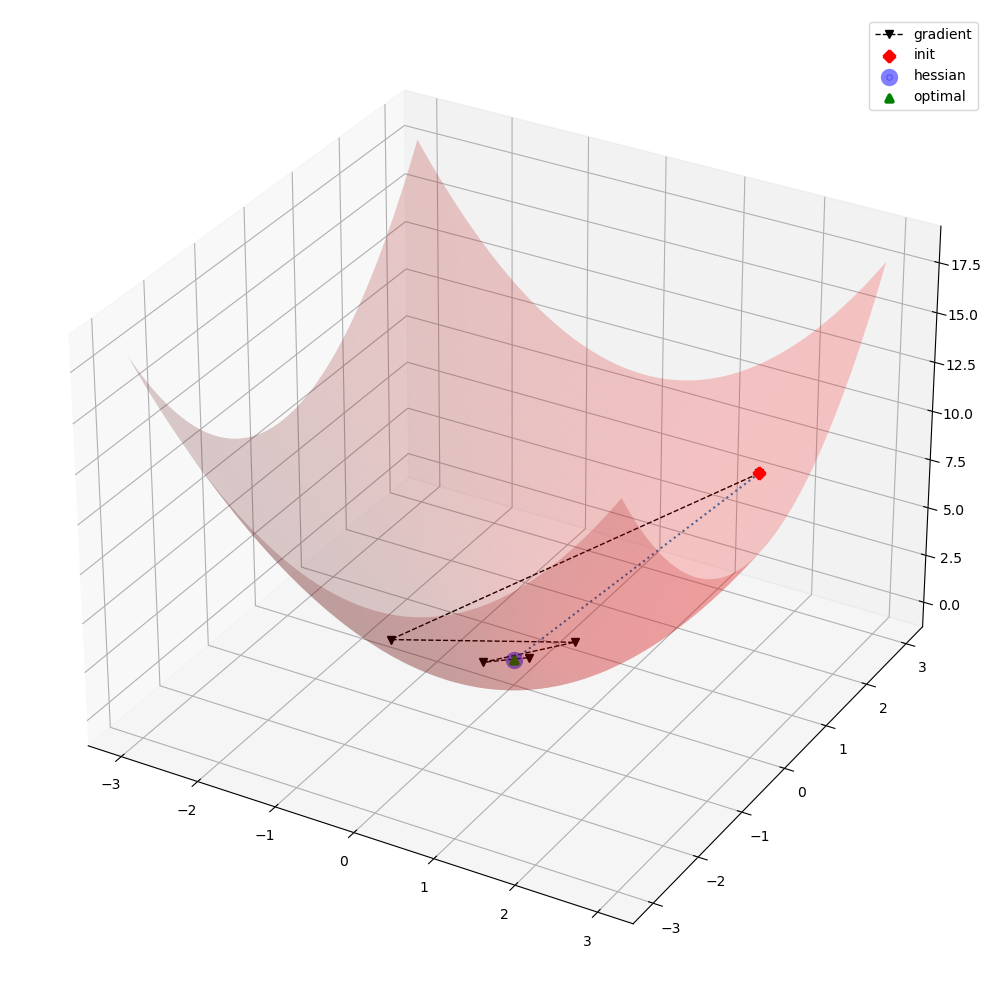

In [4]:
plot_loss_surface_and_updates(squared_fn, show_optimal=True)

tensor([10., 10.])
tensor([1., 1.])
tensor([0.4300, 0.4300])
tensor([0.2033, 0.2033])
tensor([0.1000, 0.1000])
Hessian at point tensor([2., 2.]) is tensor([[12.,  0.],
        [ 0., 12.]])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
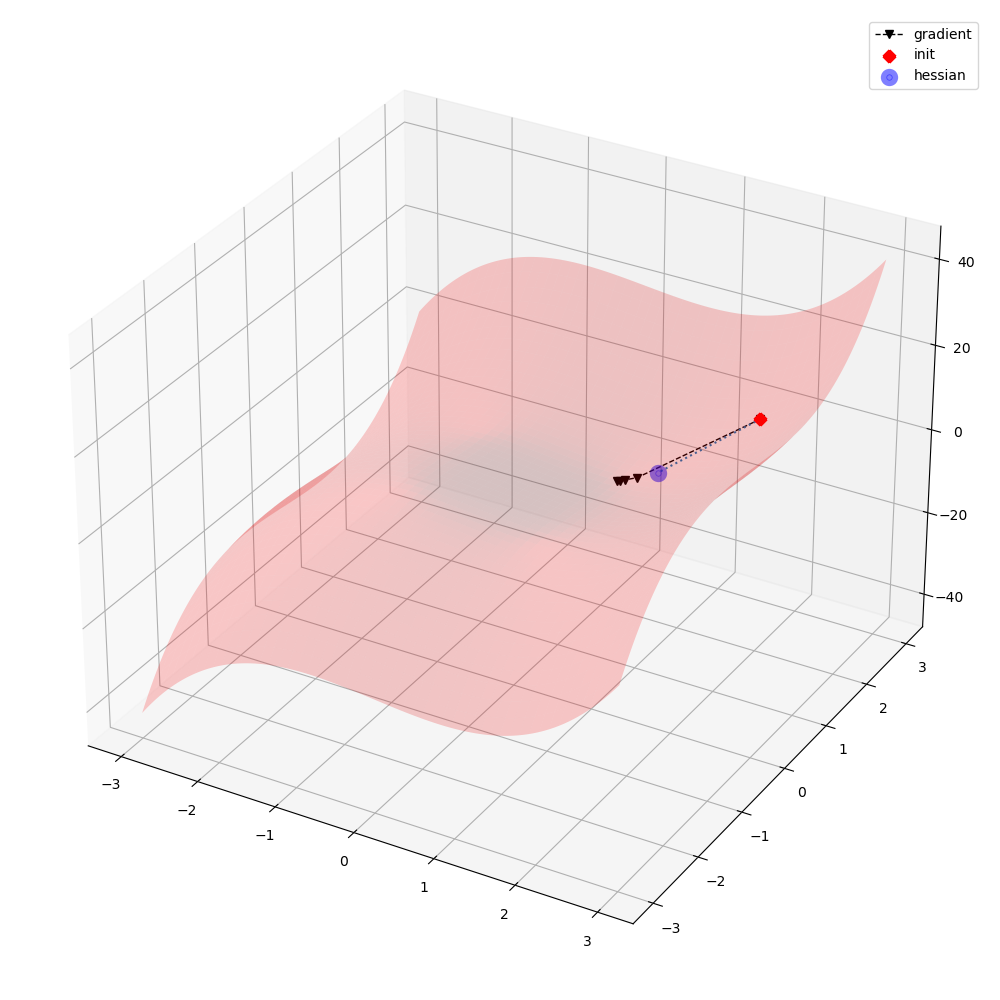

In [5]:
## add note about learning rate

def nonlinear_fn(x):
    fn = x**3 - 2*x
    return fn.sum(axis=-1)

plot_loss_surface_and_updates(nonlinear_fn, learning_rate=1e-1)

In [6]:
def random_generate_points(parameters, num_points, outlier_points, extreme_outlier_points, red = True, example4 = False):
    """
    Randomly generate points such that a large cluster lives at [1, a+b] for num_points-outlier_points points, and the rest lives on the line ax+b with noise.
    args:
        parameters: a length 3 list [a b sigma] that describes the underlying true linear line y = ax+b and the level of loss
        num_points: number of clustered data points near the true line
        outlier_points: number of non-clustered datapoints near the true line
        extreme_outlier_points: number of datapoints far from true line
        red: a boolean variable signaling if generated data points are red points (as opposed to blue points)
        example4: a boolean variable signaling if we are generating points for Example 4. 
    """
    a = parameters[0]
    b = parameters[1]
    sigma = parameters[2]
    
    x1 = np.random.uniform(0.8,1.2, size = [num_points,1])
    x2 = np.random.uniform(-5, 5, size = [outlier_points,1])
    x = np.concatenate((x1, x2))
    points = np.random.normal(a*x+b, sigma, size = [num_points+ outlier_points,1])
    out = np.concatenate((x,points),axis = 1)   
    x3 = np.random.uniform(2, 5, size = [extreme_outlier_points,1])
    
    if not example4:
        if red == True:
            extreme_points = np.random.normal(a*x3+b + 20, sigma, size = [extreme_outlier_points,1])
        else:
            x3 = np.random.uniform(-30, -25, size = [extreme_outlier_points,1])
            extreme_points = np.random.normal(a*x3+b - 50, sigma, size = [extreme_outlier_points,1])
        ext = np.concatenate((x3, extreme_points),axis = 1)

        out = np.concatenate((out, ext))

        return out
    else:
        x4 = np.random.uniform(12, 18, size = [extreme_outlier_points,1])
        if red == True:
            extreme_points = np.random.normal(a*x4+b, sigma, size = [extreme_outlier_points,1])
        else:
            extreme_points = np.random.normal(a*x4+b+30, 10*sigma, size = [extreme_outlier_points,1])
        ext = np.concatenate((x4, extreme_points),axis = 1)

        out = np.concatenate((out, ext))

        return out

In [7]:
def update_weight(loss_fn, w, X0, X1, learning_rate=1.0, use_hessian=True):
    """
    Automatic Differentiation.

    Args:
        loss_fn : cost function
        w : parameters defining the decision boundary
        X0 : positively labelled examples
        X1 : negatively labelled examples
    """

    inputs = (w, X0, X1)
    loss = loss_fn(*inputs)

    # to evaluate derviatives we use jacobian() 
    all_grad = autograd.functional.jacobian(loss_fn, inputs)
    grad = all_grad[0]

    if use_hessian:
        all_hessian = autograd.functional.hessian(loss_fn, inputs)
        hessian = all_hessian[0][0].squeeze()
        update = hessian.inverse() @ grad
    else:
        update = grad
    
    w = w - learning_rate * update
    return w, loss

def logistic_loss(w, X0, X1):
    p0 = X0 @ w
    p1 = X1 @ w
    return torch.sum(torch.log(1+torch.exp(-p0)) + torch.log(1+torch.exp(p1)))

def exponential_loss(w, X0, X1):
    p0 = X0 @ w
    p1 = X1 @ w
    return torch.sum(torch.exp(-p0) + torch.exp(p1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
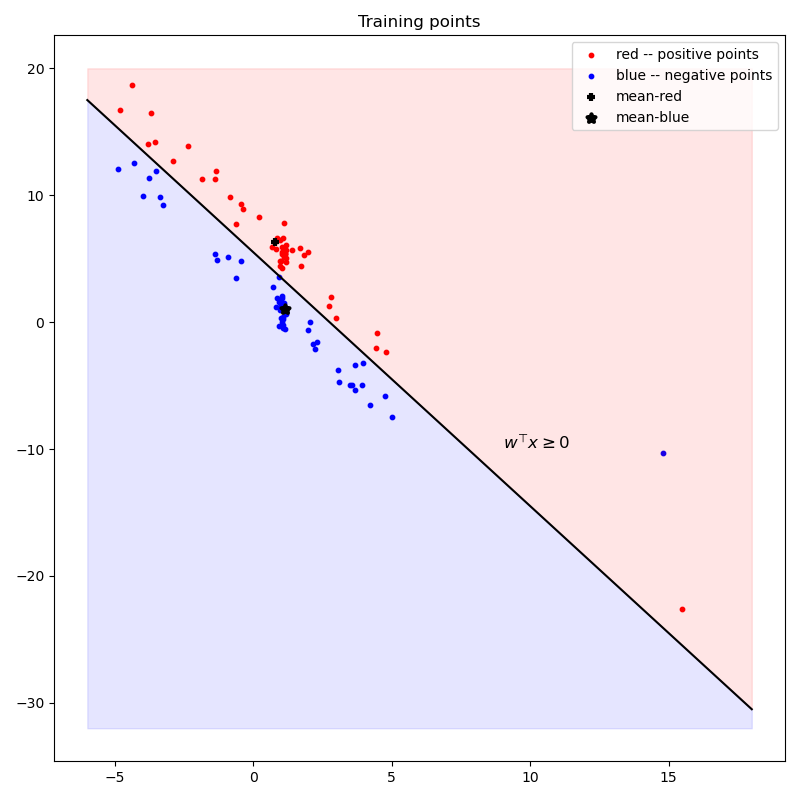

In [8]:
def get_line_val(x, w):
    return (-w[0]/w[1]) * x - w[2] / w[1]

red_points_parameters = [-2, 8, 1] # = [a,b,sigma], assuming y ~ ax+b 
blue_points_parameters = [-2, 3, 1]

num_points = 20 # number of red or blue points
outlier_points = 30
extreme_outlier_points = 1

ar_red = random_generate_points(red_points_parameters, num_points, outlier_points, 
                                extreme_outlier_points, example4 = True)
ar_blue = random_generate_points(blue_points_parameters, num_points, outlier_points, 
                                 extreme_outlier_points, red = False, example4 = True)

mean_red = ar_red.mean(axis=0)
mean_blue = ar_blue.mean(axis=0)


line_x_axis = np.arange(-6,19,1)
true_y_axis = [red_points_parameters[0]*i + (red_points_parameters[1]+blue_points_parameters[1])/2 for i in line_x_axis]

# Plot dataset
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red -- positive points', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue -- negative points', color='b', s=10)
ax.plot(line_x_axis, true_y_axis, color='black')

ax.fill_between(line_x_axis, true_y_axis, 20, color='red', alpha=0.1)
ax.fill_between(line_x_axis, true_y_axis, -32, color='blue', alpha=0.1)

ax.scatter(mean_red[0], mean_red[1], marker='+', color='black', linewidths=3, label='mean-red')
ax.scatter(mean_blue[0], mean_blue[1], marker='*', color='black',  linewidths=3, label='mean-blue')

ax.text(9, -10, r'$w^\top x \geq 0$', fontsize=12)
plt.title('Training points')
plt.tight_layout()
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
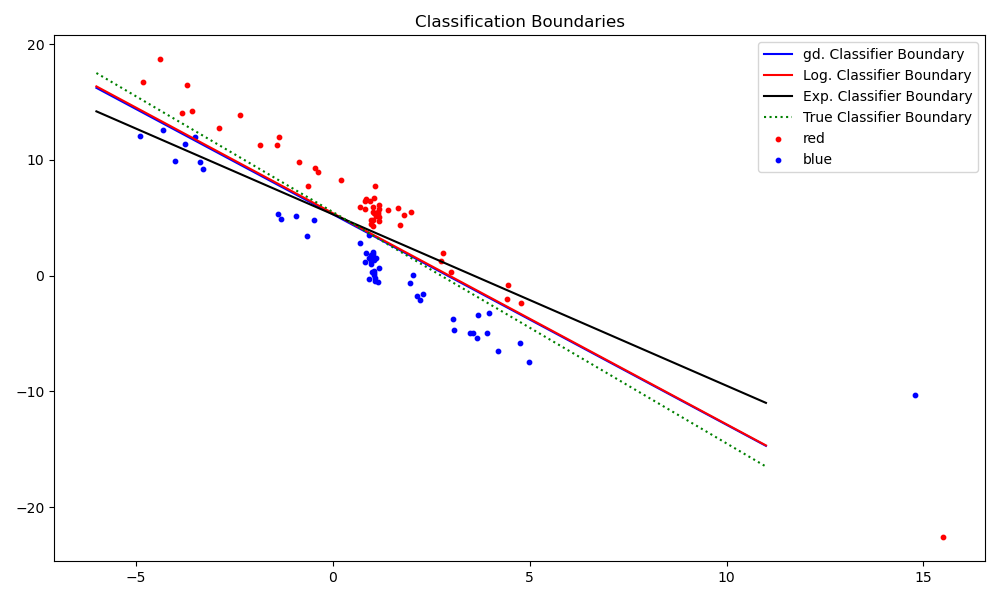

In [9]:
w_log = torch.zeros((3,1))
w_exp = torch.zeros((3,1))
w_gd = torch.zeros((3,1))
concatenated_red = np.concatenate((ar_red, np.ones((ar_red.shape[0],1))), axis = 1)
concatenated_blue = np.concatenate((ar_blue, np.ones((ar_blue.shape[0],1))), axis = 1)

all_losses = {
    "gd" : [],
    "log" : [],
    "exp" : []
}

all_weights = {
    "gd" : [],
    "log" : [],
    "exp" : []
}

red_points = torch.tensor(concatenated_red, dtype=torch.float32)
blue_points = torch.tensor(concatenated_blue, dtype=torch.float32)

for i in range(10):
    w_log, loss_log = update_weight(logistic_loss, w_log, red_points, blue_points)
    w_exp, loss_exp = update_weight(exponential_loss, w_exp, red_points, blue_points)
    w_gd, loss_gd = update_weight(logistic_loss, w_gd, red_points, blue_points, learning_rate=2e-3, use_hessian=False)
    # logging losses 

    all_losses["gd"].append(loss_gd)
    all_losses["log"].append(loss_log)
    all_losses["exp"].append(loss_exp)

    # logging weights
    all_weights["log"].append(w_log[:, 0])
    all_weights["exp"].append(w_exp[:, 0])
    all_weights["gd"].append(w_gd[:, 0])

for i in range(1000):
    w_gd, loss_gd = update_weight(logistic_loss, w_gd, red_points, blue_points, learning_rate=2e-3, use_hessian=False)

     # logging losses 
    all_losses["gd"].append(loss_gd)
    all_losses["log"].append(loss_log)
    all_losses["exp"].append(loss_exp)

    # logging weights
    all_weights["gd"].append(w_gd[:, 0])
    all_weights["log"].append(w_log[:, 0])
    all_weights["exp"].append(w_exp[:, 0])

line_x_axis = np.arange(-6,12,1)

line_y_axis_gd = [get_line_val(i, w_gd.numpy()) for i in line_x_axis]
line_y_axis_log = [get_line_val(i, w_log.numpy()) for i in line_x_axis]
line_y_axis_exp = [get_line_val(i, w_exp.numpy()) for i in line_x_axis]

true_y_axis = [red_points_parameters[0]*i + (red_points_parameters[1]+blue_points_parameters[1])/2 for i in line_x_axis]

fig = plt.figure(figsize=(10, 6))
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title('Classification Boundaries')
plt.plot(line_x_axis, line_y_axis_gd, label='gd. Classifier Boundary', color='b')
plt.plot(line_x_axis, line_y_axis_log, label='Log. Classifier Boundary', color='r')
plt.plot(line_x_axis, line_y_axis_exp, label='Exp. Classifier Boundary', color='k')
plt.plot(line_x_axis, true_y_axis, label = 'True Classifier Boundary', color = 'g', linestyle='dotted')
plt.tight_layout()
plt.legend()
plt.show()

## Visualizing the loss across updates

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
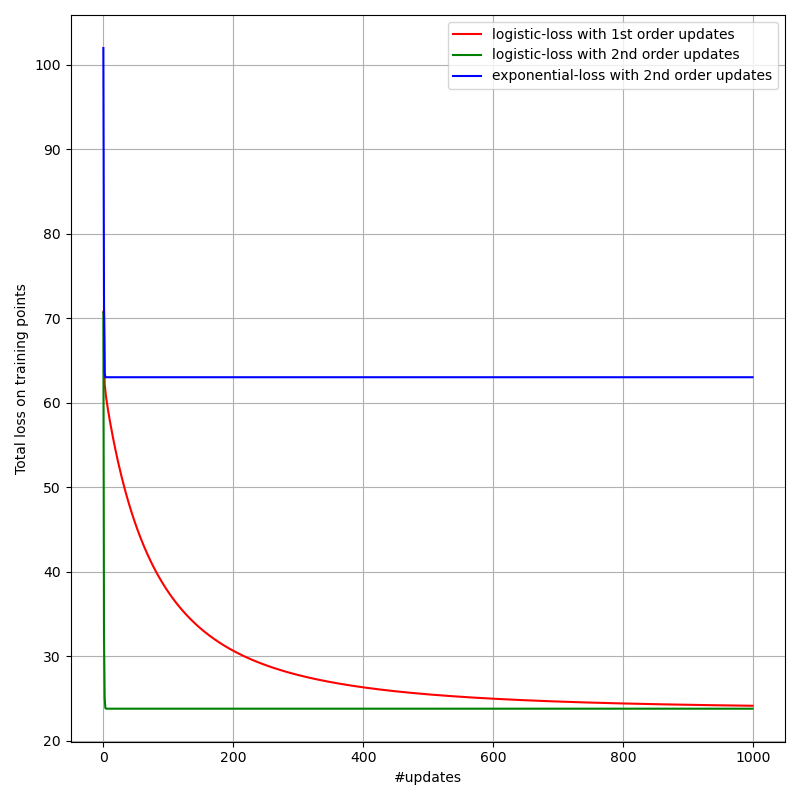

In [10]:
fig = plt.figure(figsize=(8,8))
num_steps = 1000
plt.plot(all_losses["gd"][:num_steps], color='red', label='logistic-loss with 1st order updates')
plt.plot(all_losses["log"][:num_steps], color='green', label='logistic-loss with 2nd order updates')
plt.plot(all_losses["exp"][:num_steps], color='blue', label='exponential-loss with 2nd order updates')
plt.ylabel("Total loss on training points")
plt.xlabel("#updates")
plt.tight_layout()
plt.grid()
plt.legend()

## Visualizing learned parameters

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
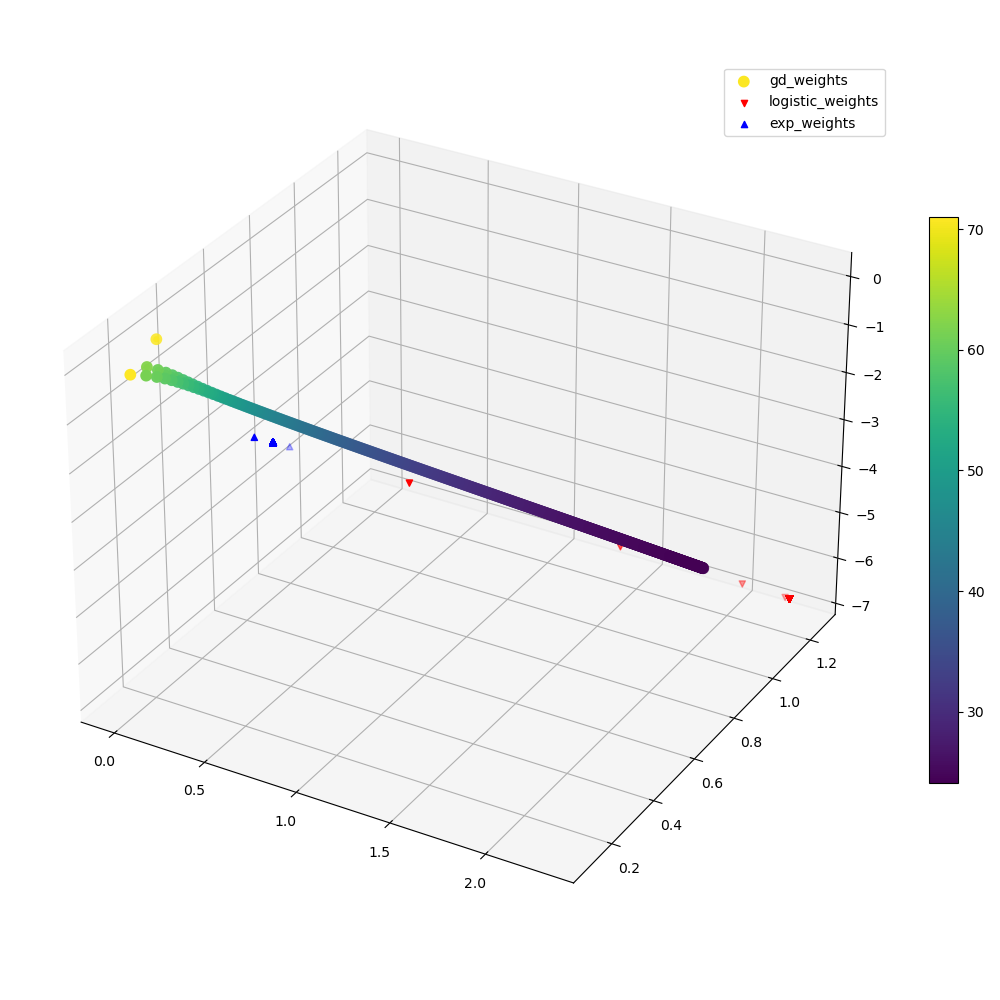

In [11]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
gd_weights = np.vstack(all_weights['gd'])
log_weights = np.vstack(all_weights['log'])
exp_weights = np.vstack(all_weights['exp'])
img = ax.scatter(gd_weights[:, 0], gd_weights[:, 1], gd_weights[:, 2], c=all_losses["gd"], label='gd_weights', marker='o', linewidths=4)
ax.scatter(log_weights[:, 0], log_weights[:, 1], log_weights[:, 2], color='red', label='logistic_weights', marker='v')
ax.scatter(exp_weights[:, 0], exp_weights[:, 1], exp_weights[:, 2], color='blue', label='exp_weights', marker='^')
fig.colorbar(img, fraction=0.03, pad=0.04)
plt.tight_layout()
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
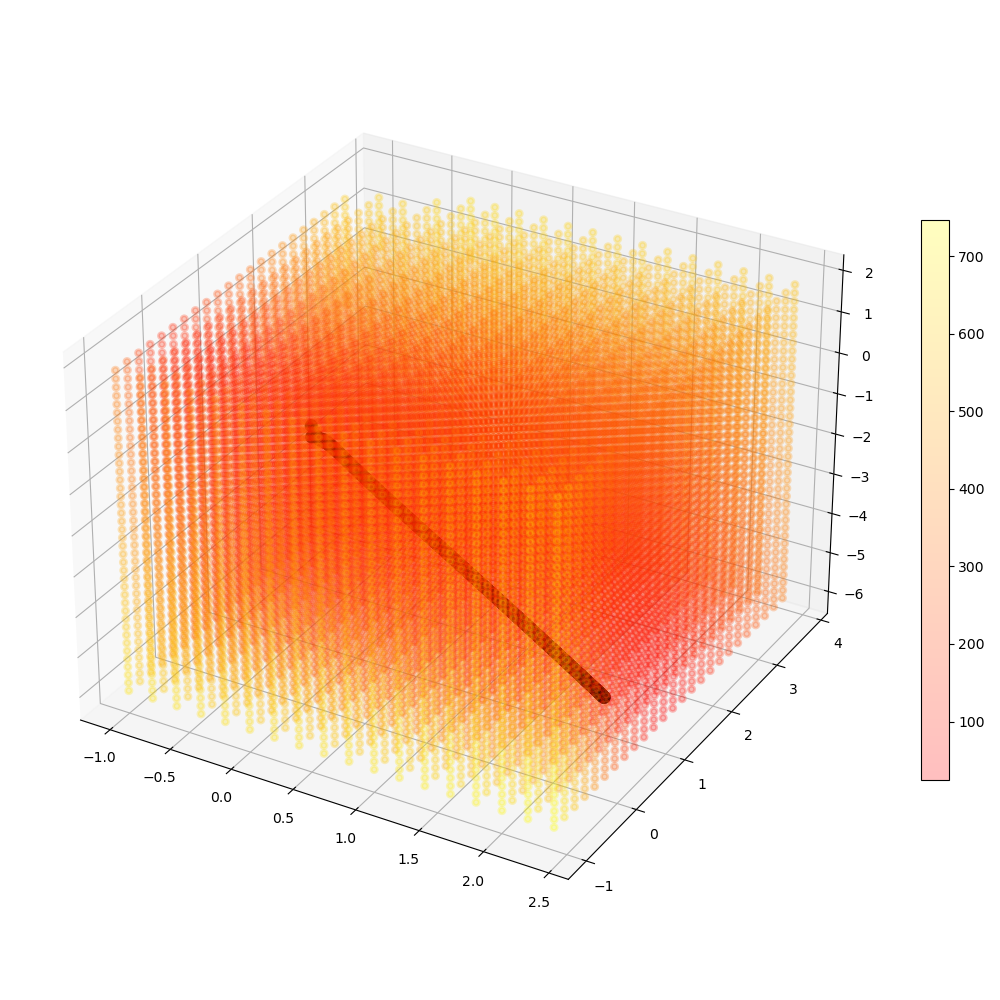

In [13]:

w1 = np.arange(-1, 2.5, 0.2)
w2 = np.arange(-1, 4, 0.2)
w3 = np.arange(-6, 2, 0.2)
points = np.array(np.meshgrid(w1, w2, w3)).reshape(3, -1).T

z = [logistic_loss(torch.tensor([w[0], w[1], w[2]], dtype=torch.float32), red_points, blue_points) for w in points]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
ax.scatter(gd_weights[:, 0], gd_weights[:, 1], gd_weights[:, 2], c='black', label='gd_weights', marker='o', linewidths=5)
img = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=z, alpha=0.25, cmap='autumn', linewidths=2)
ax.set_label('a')
fig.colorbar(img,  fraction=0.03, pad=0.04)
plt.tight_layout()
plt.show()


In [15]:
X = np.concatenate((ar_red, ar_blue))
n = len(X)

# Add column of ones to account for bias term
X = np.concatenate((X, np.ones((n,1))), axis=1)

# Create y array of class labels
y = np.concatenate((np.ones(int(n/2)), -np.ones(int(n/2))))

# Calculate the Ordinary Least Squares solution
beta = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Plot the resulting regression line
line_y_LS = -beta[0] / beta[1] * line_x_axis - beta[2] / beta[1] 

c_red = torch.tensor(concatenated_red, dtype=torch.float32)
c_blue = torch.tensor(concatenated_blue, dtype=torch.float32)

def update(num_updates=1):
    w_log = torch.zeros((3,1))
    w_exp = torch.zeros((3,1))
    w_gd = torch.zeros((3,1))
    for idx in range(min(10, num_updates)):
        w_log, _ = update_weight(logistic_loss, w_log, c_red, c_blue)
        w_exp, _ = update_weight(exponential_loss, w_exp, c_red, c_blue)

    for idx in range(num_updates):
        w_gd, _ = update_weight(logistic_loss, w_gd, c_red, c_blue, learning_rate=2e-3, use_hessian=False)
        
    line_x_axis = np.arange(-6,12,1)
    line_y_axis_gd = [get_line_val(i, w_gd.numpy()) for i in line_x_axis]
    line_y_axis_log = [get_line_val(i, w_log.numpy()) for i in line_x_axis]
    line_y_axis_exp = [get_line_val(i, w_exp.numpy()) for i in line_x_axis]
    true_y_axis = [red_points_parameters[0]*i + (red_points_parameters[1]+blue_points_parameters[1])/2 for i in line_x_axis]

    fig = plt.figure(figsize=(10, 6))
    plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
    plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
    plt.title('Classification Boundaries')
    plt.plot(line_x_axis, line_y_axis_gd, label='GD+Logistic Classifier Boundary', color='b')
    plt.plot(line_x_axis, line_y_axis_log, label='Logistic Classifier Boundary', color='r')
    plt.plot(line_x_axis, line_y_axis_exp, label='Exponential Classifier Boundary', color='k')
    plt.plot(line_x_axis, true_y_axis, label = 'True Classifier Boundary', color = 'g', linestyle='dotted')
    plt.legend()
    plt.show()

slide_plt = interactive(
    update, num_updates=widgets.IntSlider(value=0, min=1, max=1000, step=1, description="num_updates"))
output = slide_plt.children[-1]
slide_plt

interactive(children=(IntSlider(value=1, description='num_updates', max=1000, min=1), Output()), _dom_classes=…

[FA21 Dis13A] Notebook to explore automatic differentiation and using that for learning classifiers.

Contributors:
- Kumar Krishna Agrawal